In [6]:
import os
import matplotlib.pyplot as plt
import pyspark.sql.functions as psf
from pyspark.sql.functions import col,udf
from  pyspark.sql.types import *

In [15]:
output_dir = "/tmp/Misiutin"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
project_dir = "/home/kommiu/Projects/bd_incubator_ta/"
input_file_name = "sflow-0118.csv"

In [13]:
names = "Timestamp FLOW_indicator Agent_address Input_port \
    Output_port Src_MAC Dst_MAC Ethernet_type In_vlan Out_vlan \
    Src_ip Dst_ip Ip_protocol Ip_tos Ip_ttl Udp_src_port_OR_tcp_src_port_OR_icmp_type \
    Udp_dst_port_OR_tcp_dst_port_OR_icmp_code \
    Tcp_flags Packet_size IP_size Sampling_rate".split()
schema = StructType([StructField(field_name, StringType(), True) for field_name in names])

In [16]:
df = spark.read.csv(os.path.join(project_dir,input_file_name),schema = schema)

In [17]:
src = df.select(df["Src_ip"].alias("ip"), df["Packet_size"].cast(IntegerType()).alias('size'), df['Sampling_rate'].alias('Sr'))
dst = df.select(df["Dst_ip"].alias("ip"), df["Packet_size"].cast(IntegerType()).alias('size'), df['Sampling_rate'].alias('Sr'))
data = src.union(dst)
data.cache()

DataFrame[ip: string, size: int, Sr: string]

In [21]:
byIP = data.groupBy('ip').agg(psf.sum('size').alias('sum'))
byIP.cache()
byIP.write.json(os.path.join(output_dir,'byIP_sampled'), mode='overwrite')

In [22]:
def get_country(ip):
    from geoip2.database import Reader
    from geoip2.errors import AddressNotFoundError
    try:
        reader = Reader(os.path.join(project_dir,'GeoLite2-Country.mmdb'))
        response = reader.country(ip)
        country = response.country.name
        return  country if country else "NOT_FOUND"
    except AddressNotFoundError:
        return "NOT_FOUND"
udf_get_country = udf(get_country,StringType())

In [23]:
withCountry = byIP.withColumn('country',udf_get_country(col('ip')))
withCountry.cache()

DataFrame[ip: string, sum: bigint, country: string]

In [27]:
byCountry = withCountry.groupBy('country').agg(psf.sum('sum').alias('sum'))
byCountry.cache()
byCountry.coalesce(1).write.json(os.path.join(output_dir,'byCountry_sampled'),mode='overwrite')

In [28]:
byCountry_pd = byCountry.sort('sum').toPandas()

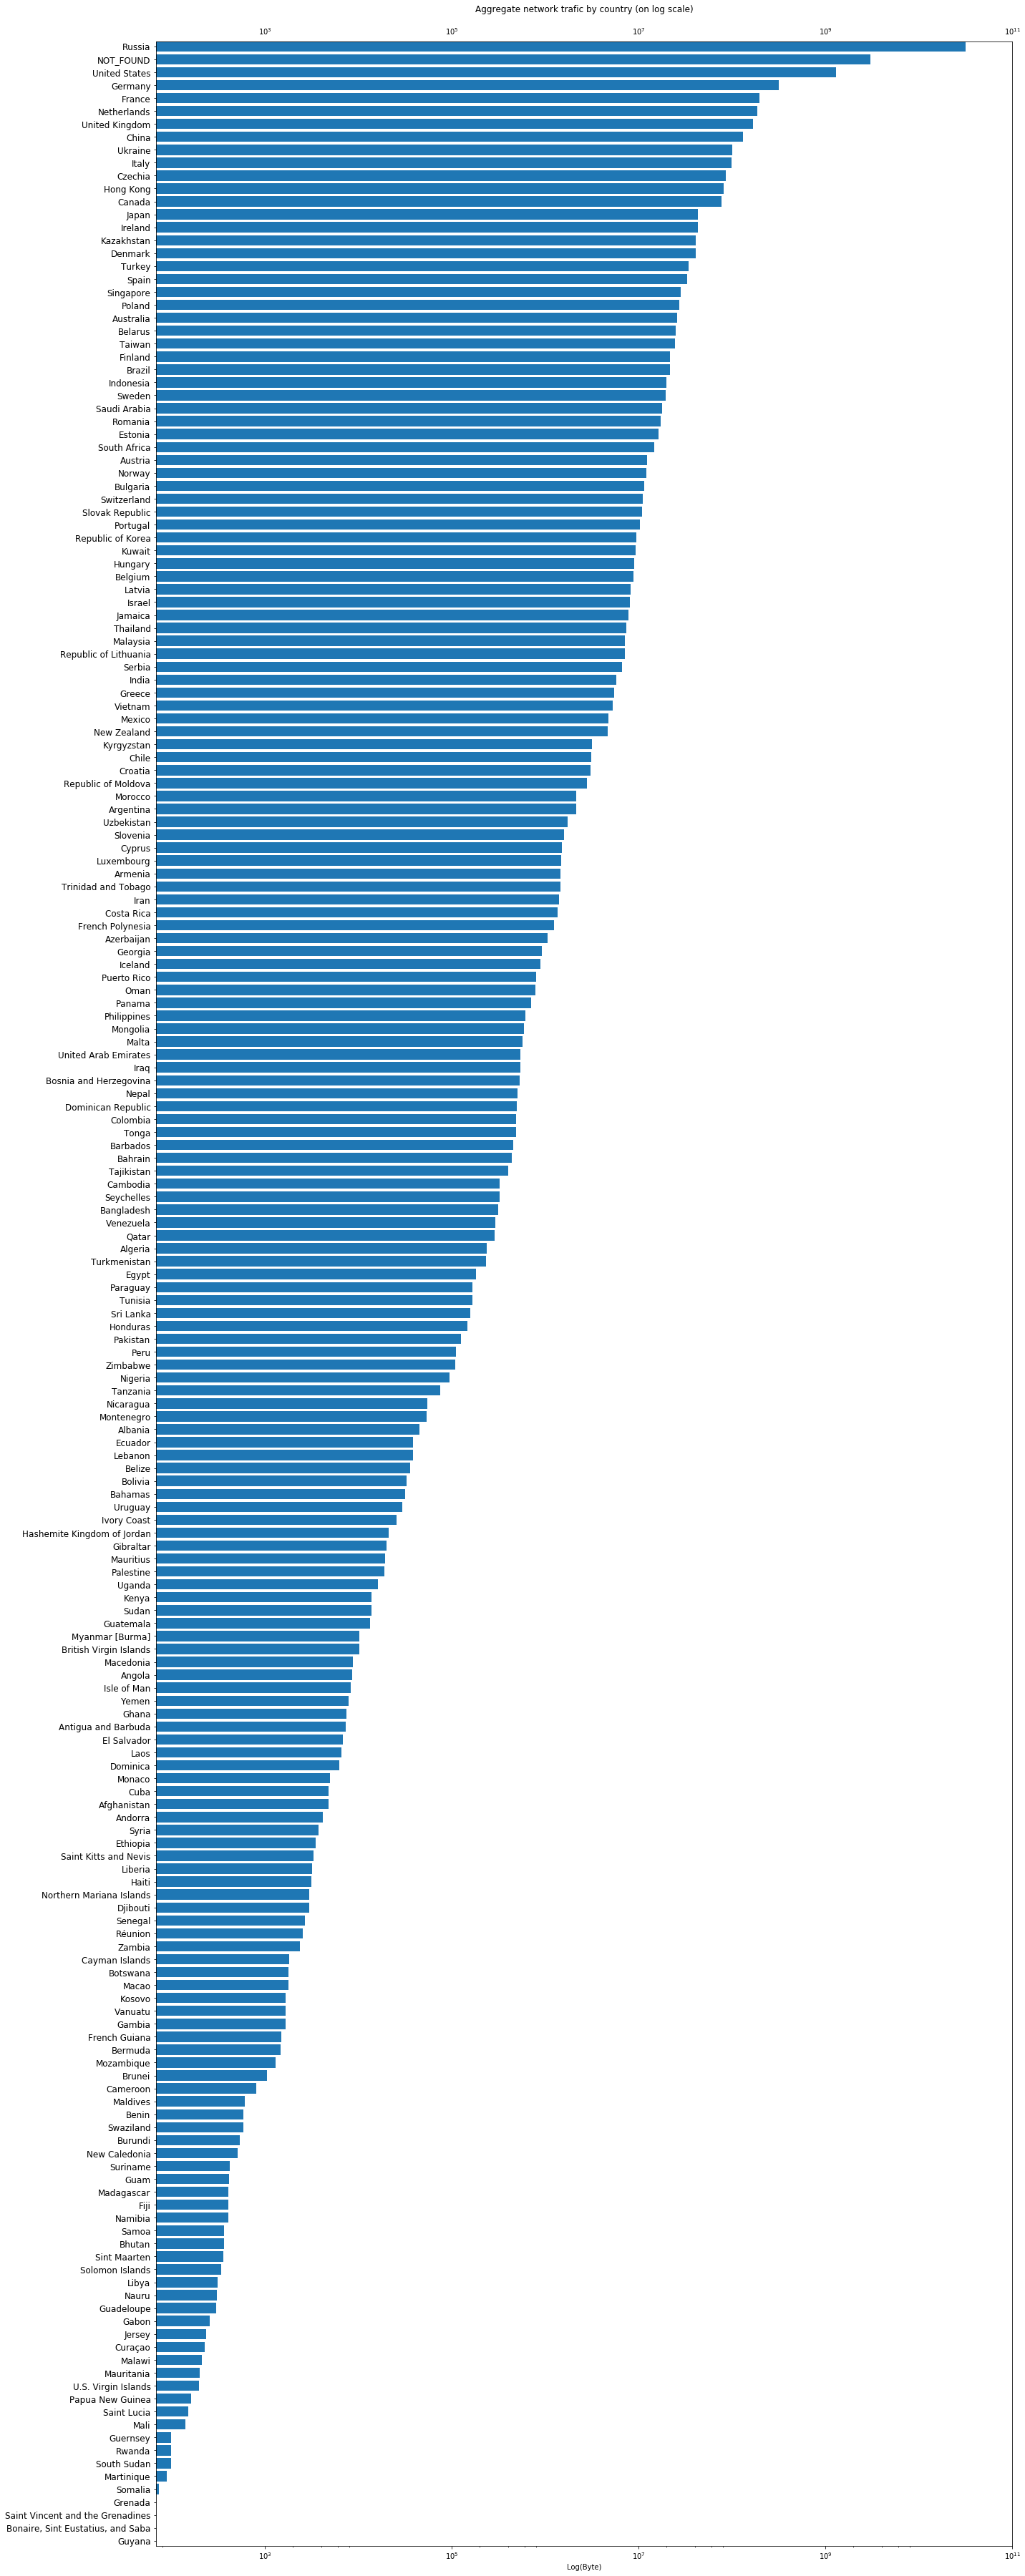

In [29]:
index = range(byCountry_pd.shape[0])
fig,ax = plt.subplots(figsize=(20,50))
ax.barh(index, byCountry_pd['sum'])
ax.set_xscale('log')
ax.set_xlabel('Log(Byte)')
ax.set_title('Aggregate network trafic by country (on log scale)',y=1.01)
ax.margins(0,0)
ax.set_xlim(0,1e11)
ax.tick_params(labeltop='on')
plt.yticks(index, byCountry_pd['country'], rotation='horizontal',fontsize=12)
fig.tight_layout()
plt.show()
fig.savefig('vertical_plot.png')
plt.close(fig)

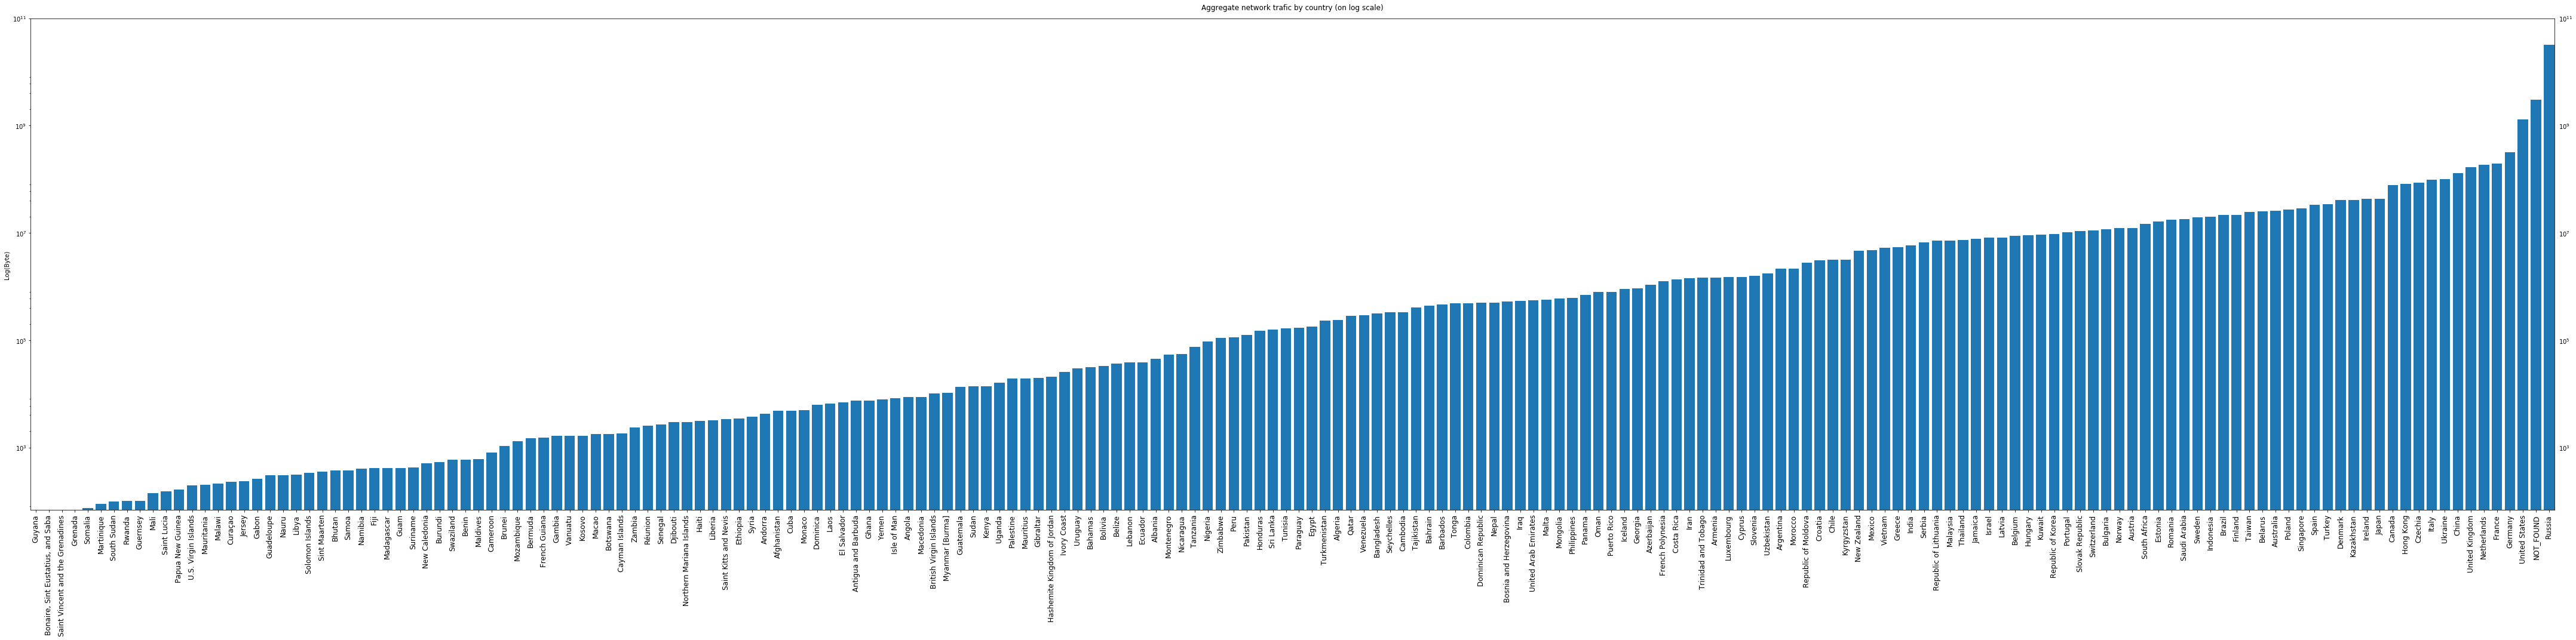

In [30]:
fig,ax = plt.subplots(figsize=(60,15))
ax.bar(index, byCountry_pd['sum'])
ax.set_yscale('log')
ax.set_ylabel('Log(Byte)')
ax.set_title('Aggregate network trafic by country (on log scale)',y=1.01)
ax.margins(0,0)
ax.set_ylim(0,1e11)
ax.tick_params(labelright='on')
plt.xticks(index, byCountry_pd['country'], rotation='vertical',fontsize=12)
fig.tight_layout()
plt.show()
fig.savefig('horizontal_plot.png')
plt.close(fig)

## 4. Дополнительный бонус 1
Изучить sFlow и объяснить почему подсчет трафика, вычисляемый как указано выше, не является корректным, реализовать в задании корректный вариант: http://www.sflow.org/packetSamplingBasics/index.htm

Поскольку представленный датасет содержит только случайную выборку из всего трафика за рассматриваемый период, то посчитанные выше распределения трафика(по адресам и странам) не являются корректными.

Чтобы получить оценку трафика за весь период используем форумулу (18) из приведенной в задании статьи: $B_c=\bar{b_c}N_c$, с учетом формул (19) и (12) получим $B_c=\bar{b_c}N_c=\frac{\sum{b_{ci}}}{c}*\frac{c*N}{n}=\sum{b_{ci}}*sampling\_rate$,
Вычислим так же дисперсию нашей оценки, опуская элементарные преобразования, получим из формул (22), (20), (19), (12), (13) следующее выражение:
$var(B_c) = $

$\frac{1}{2}$

In [31]:
n = sc.broadcast(data.count())
sr = sc.broadcast(512)


In [32]:
df.select("Sampling_rate").distinct().collect()

[Row(Sampling_rate='512')]

In [40]:
byIP_fxd = data.groupBy('ip').agg(psf.sum(col('size')).alias('sum'),\
        psf.sum(col('size')**2).alias('sumSq'),psf.count('ip').alias('count'))
byIP_fxd.cache()

DataFrame[ip: string, sum: bigint, sumSq: double, count: bigint]

In [151]:
from string import Template
query = Template('''
    SELECT $type, sum*$sr AS trafic_estimate,
        SQRT(vbm*vn+vn*POWER(sum/count,2)+vbm*POWER(count*$sr,2)) AS standard_deviation 
    FROM (SELECT 
            $type,count,sum,(sumSq - POWER(sum,2)/count)/(count-1) AS vbm,
            ($sr*count*($n-count))/($n-1) AS vn 
        FROM $table)
''')

In [159]:
byIP_fxd.createOrReplaceTempView('byIP')
byIP_est = spark.sql(query.substitute(table='byIP',sr=sr.value,n=n.value,type='ip'))
byIP_est.cache()
byIP_est.show(10)

In [165]:
byCountry_fxd = byIP_fxd.withColumn('country',udf_get_country(col('ip')))\
    .groupBy('country').agg(psf.sum(col('sum')).alias('sum')\
    ,psf.sum(col('sumSq')).alias('sumSq'),psf.sum('count').alias('count'))

In [163]:
byCountry_fxd.createOrReplaceTempView('byCountry')
byCountry_est = spark.sql(query.substitute(table='byCountry',sr=sr.value,n=n.value,type='country'))
byCountry_est.cache()
byCountry_est.show(10)

DataFrame[country: string, trafic_estimate: bigint, standard_deviation: double]

In [ ]:
byIP_est.write.json(os.path.join(output_dir,'byIP_estimate'),mode='overwrite')
byCountry_est.coalesce(1).write\
    .json(os.path.join(output_dir,'byCountry_estimate'),mode='overwrite')